## Packages and Assets

In [21]:
from gensim.models import Word2Vec
import json
import numpy as np
import pandas as pd

import seaborn as sns

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

import matplotlib.pyplot as plt

from keras.preprocessing.text import tokenizer_from_json

In [22]:
# with open('../../assets/word_index.json', 'r') as f:
#     word_index = json.load(f)
#     word_index = dict(word_index)

In [23]:
with open('../../assets/lstm_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

In [24]:
train = pd.read_csv('../../assets/data/splits/train/padded.csv')
val = pd.read_csv('../../assets/data/splits/val/padded.csv')

X_train = train.to_numpy()[:, :-1]
y_train = train.to_numpy()[:, -1]

X_val = val.to_numpy()[:, :-1]
y_val = val.to_numpy()[:, -1]

In [25]:
model_we = Word2Vec.load('../../assets/lstm_assets/word2vec.model')

model_we.wv.most_similar('petrobras')

[('petr4', 0.9969706535339355),
 ('venda', 0.9732074737548828),
 ('diz', 0.9684100151062012),
 ('arrecada', 0.9663283824920654),
 ('sal', 0.9640135169029236),
 ('natural', 0.9576036334037781),
 ('premenos', 0.9558805227279663),
 ('inicia', 0.9553847312927246),
 ('bolsonaro', 0.9515899419784546),
 ('governo', 0.9483191967010498)]

In [26]:
# List of nparrays of size 300
embeddings_dict = {}
for word in model_we.wv.index_to_key:
    embeddings_dict[word] = model_we.wv[word]

In [27]:
# create matrix with vocab train words
embeddings_on_this_context = np.zeros((len(word_index), 300))
for word, i in word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_on_this_context[i - 1] = embeddings_vector

## Functions

In [28]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

## RNN Model

### Declaration

In [29]:
model = Sequential([
    Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(64, return_sequences=True)),
    # Dropout(0.4),
    # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    # Dropout(0.6),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 300)           2405100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,695,023
Trainable params: 289,923
Non-

### Training

In [30]:
from keras.optimizers import SGD

loss = "sparse_categorical_crossentropy"
optimizer = SGD(learning_rate=0.01)
metrics = ['accuracy']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val,y_val), verbose=2)

Epoch 1/25
299/299 - 13s - loss: 1.0071 - accuracy: 0.5064 - val_loss: 0.9958 - val_accuracy: 0.5084 - 13s/epoch - 45ms/step
Epoch 2/25
299/299 - 4s - loss: 0.9714 - accuracy: 0.5360 - val_loss: 0.9623 - val_accuracy: 0.5452 - 4s/epoch - 15ms/step
Epoch 3/25
299/299 - 6s - loss: 0.9348 - accuracy: 0.5789 - val_loss: 0.9160 - val_accuracy: 0.6054 - 6s/epoch - 20ms/step
Epoch 4/25
299/299 - 5s - loss: 0.8894 - accuracy: 0.6139 - val_loss: 0.8641 - val_accuracy: 0.6263 - 5s/epoch - 16ms/step
Epoch 5/25
299/299 - 5s - loss: 0.8371 - accuracy: 0.6416 - val_loss: 0.7978 - val_accuracy: 0.6647 - 5s/epoch - 17ms/step
Epoch 6/25
299/299 - 7s - loss: 0.7747 - accuracy: 0.6724 - val_loss: 0.7222 - val_accuracy: 0.6931 - 7s/epoch - 24ms/step
Epoch 7/25
299/299 - 5s - loss: 0.7077 - accuracy: 0.6992 - val_loss: 0.6652 - val_accuracy: 0.7249 - 5s/epoch - 18ms/step
Epoch 8/25
299/299 - 8s - loss: 0.6640 - accuracy: 0.7242 - val_loss: 0.7906 - val_accuracy: 0.6639 - 8s/epoch - 27ms/step
Epoch 9/25
299

### Evaluation

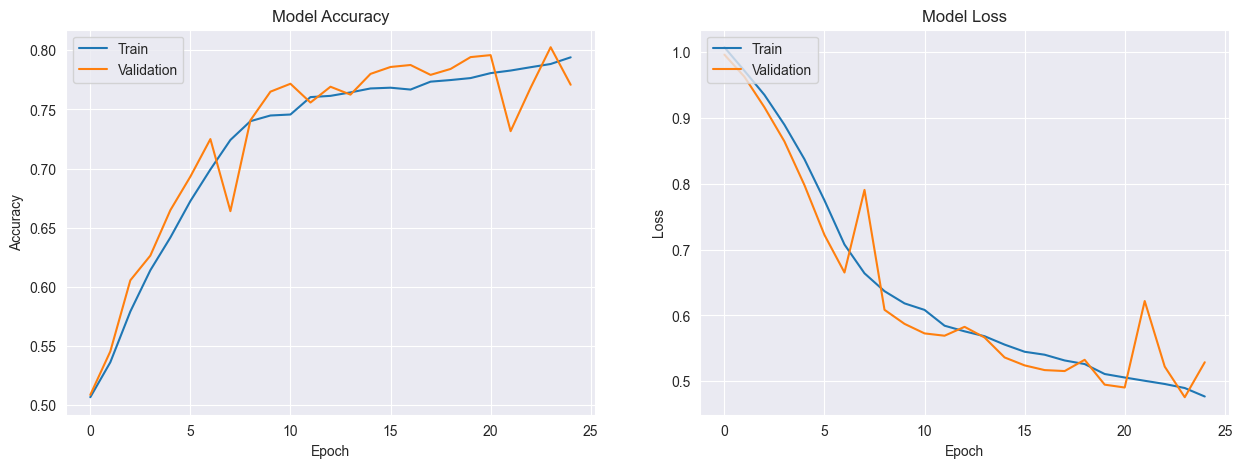

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Exporting model

In [32]:
model.save('../../assets/lstm_assets/lstm_model')

INFO:tensorflow:Assets written to: ../../assets/lstm_assets/lstm_model\assets


INFO:tensorflow:Assets written to: ../../assets/lstm_assets/lstm_model\assets
